In [37]:
import random
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.sampling.scaling import OffsetScaler
from idaes.core.surrogate.alamopy import AlamoSurrogate
from idaes.core.surrogate.keras_surrogate import (
    KerasSurrogate,
    save_keras_json_hd5,
    load_keras_json_hd5,
)
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)
np.random.seed(46)
random.seed(1342)
tf.random.set_seed(62)
tf.keras.backend.set_floatx('float64')

# dirname = os.path.dirname(__file__)
# basename = "data_atr.csv"
# fname = os.path.join(dirname, basename)

# csv_data = pd.read_csv(fname) 
csv_data = pd.read_csv("C:/Users/sbugo/surr-vs-imp/surrogate-vs-implicit/svi/auto_thermal_reformer/data_atr.csv") 

if 'Unnamed: 0' in csv_data.columns:
    csv_data = csv_data.drop('Unnamed: 0', axis=1)

# Drop columns that contain values less than 1e-6 so that the NN can train properly
csv_data = csv_data.drop(['C2H6','C3H8','C4H10','O2'], axis=1)

data = csv_data

input_data = data.iloc[:, :4]
output_data = data.iloc[:, 4:]

input_labels = input_data.columns
output_labels = output_data.columns

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(
    data, 0.8, seed=n_data
) 

# Create data objects for training using scalar normalization
n_inputs = len(input_labels)
n_outputs = len(output_labels)
x = input_data
y = output_data

input_scaler = None
output_scaler = None
input_scaler = OffsetScaler.create_normalizing_scaler(x)
output_scaler = OffsetScaler.create_normalizing_scaler(y)
x = input_scaler.scale(x)
y = output_scaler.scale(y)
x = x.to_numpy()
y = y.to_numpy()

bounds = csv_data[['Fin_CH4','Tin_CH4','Fin_H2O','Conversion']].agg(['min', 'max']).T
input_bounds = {index: (row['min'], row['max']) for index, row in bounds.iterrows()}

best_model = keras.models.load_model("C:/Users/sbugo/Downloads/keras_surrogate")
alamo_model = AlamoSurrogate.load_from_file("C:/Users/sbugo/surr-vs-imp/surrogate-vs-implicit/svi/auto_thermal_reformer/alamo_surrogate_atr.json")

keras_surrogate = KerasSurrogate(
    best_model,
    input_labels=list(input_labels),
    output_labels=list(output_labels),
    input_bounds=input_bounds,
    input_scaler=input_scaler,
    output_scaler=output_scaler,
)

4/4 [==============================] - 0s 2ms/step


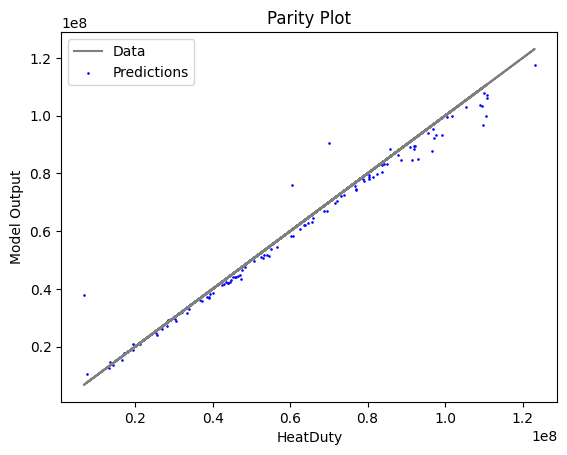

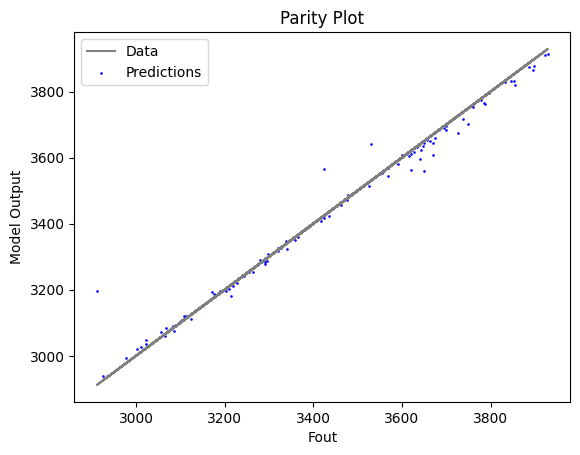

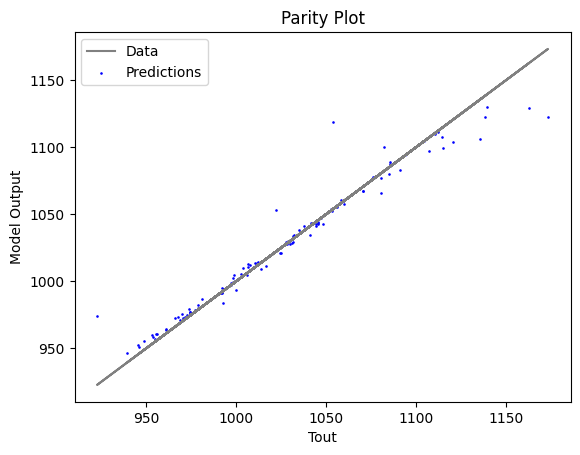

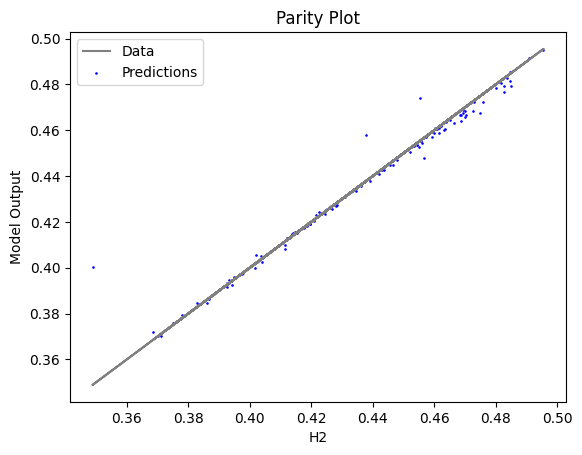

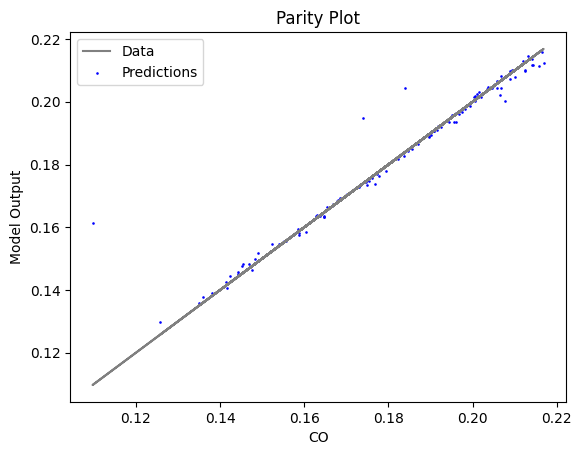

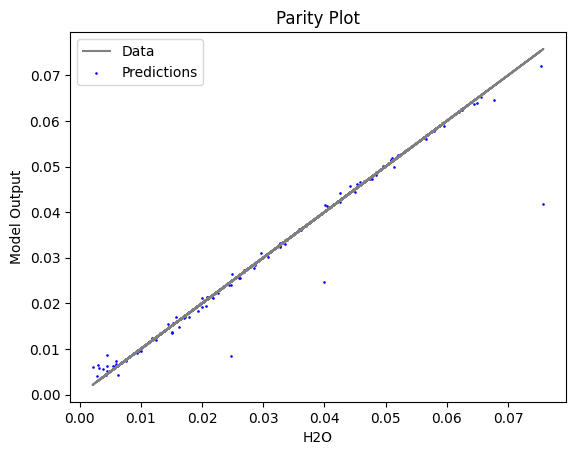

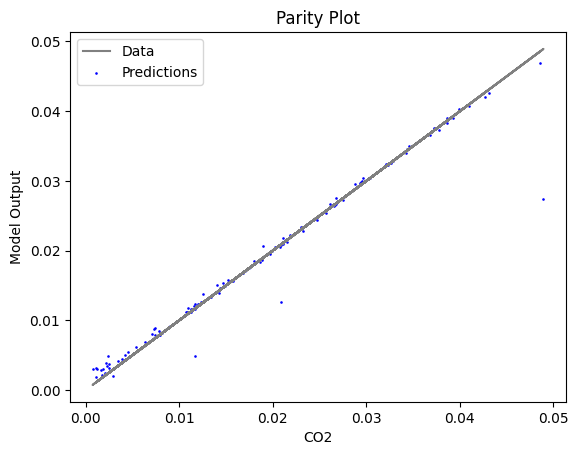

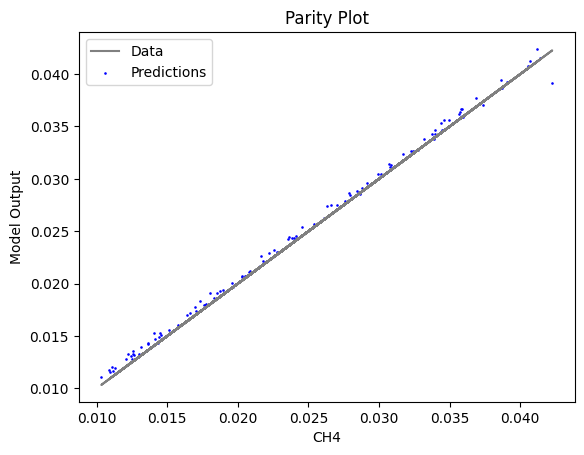

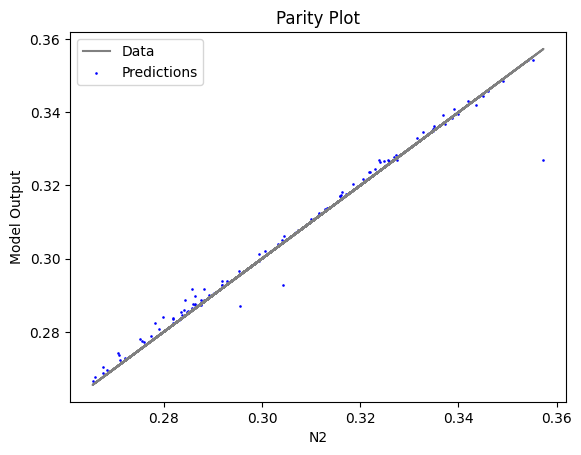

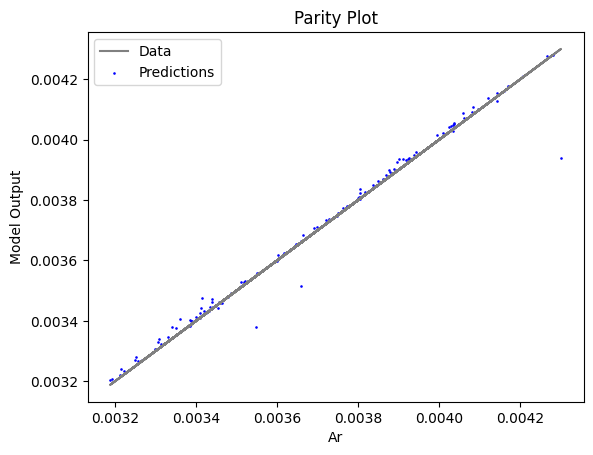

In [38]:
surrogate_parity(keras_surrogate, data_validation, filename="keras_train_parity.pdf")


In [39]:
# best_model = keras.models.load_model("C:/Users/sbugo/Downloads/keras_surrogate")

# keras_surrogate = KerasSurrogate(
#     best_model,
#     input_labels=list(input_labels),
#     output_labels=list(output_labels),
#     input_bounds=input_bounds,
#     input_scaler=input_scaler,
#     output_scaler=output_scaler,



predicted_output_data = KerasSurrogate.evaluate_surrogate(keras_surrogate,data_validation.iloc[:, :4])

4/4 [==============================] - 0s 2ms/step


In [40]:
data_validation.iloc[:, 4:]['Tout']

0      1045.439355
1      1040.802346
2      1085.352718
3      1135.725950
4       992.325677
          ...     
105    1163.027267
106    1041.834257
107    1085.430010
108     939.394411
109    1053.208718
Name: Tout, Length: 110, dtype: float64

In [41]:
predicted_output_data['Tout']

0      1043.552839
1      1034.636054
2      1087.850494
3      1106.621923
4       991.282714
          ...     
105    1129.102938
106    1043.784410
107    1088.721626
108     946.210543
109    1052.821977
Name: Tout, Length: 110, dtype: float64

In [42]:
predicted_output_data

,HeatDuty,Fout,Tout,H2,CO,H2O,CO2,CH4,N2,Ar
0,7.234661e+07,3605.925766,1043.552839,0.457236,0.201991,0.013588,0.007972,0.027934,0.288639,0.003460
1,8.067184e+07,3634.303812,1034.636054,0.452818,0.200318,0.013422,0.008117,0.035634,0.287538,0.003445
2,9.555324e+07,3683.222761,1087.850494,0.468879,0.210143,0.007447,0.004112,0.024334,0.283317,0.003411
3,8.484778e+07,3595.733270,1106.621923,0.468493,0.211575,0.005794,0.003001,0.019420,0.289761,0.003472
4,5.822341e+07,3558.965044,991.282714,0.433476,0.176275,0.033182,0.020005,0.039453,0.293312,0.003529
...,...,...,...,...,...,...,...,...,...,...
105,9.977589e+07,3701.387760,1129.102938,0.479193,0.211367,0.006523,0.003225,0.013297,0.282497,0.003379
106,7.568519e+07,3568.783404,1043.784410,0.455121,0.193082,0.025509,0.013377,0.017241,0.292812,0.003515
107,9.949029e+07,3698.452131,1088.721626,0.472549,0.209867,0.009645,0.005430,0.019260,0.282298,0.003398
108,1.060878e+07,3047.447795,946.210543,0.372141,0.129921,0.071966,0.046948,0.033788,0.341901,0.004128


In [43]:
predicted_output_data.to_csv("predicted_output_data.csv")

In [44]:
data_validation.iloc[:, 4:].to_csv("real_output_data.csv")

In [52]:
from sklearn.metrics import r2_score

y_true = predicted_output_data['Ar'].values
y_pred = data_validation.iloc[:, 4:]['Ar'].values

# Calculate the R-squared value
r2_score(y_true, y_pred)

0.9778739042495773

In [53]:
import random
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.sampling.scaling import OffsetScaler
from idaes.core.surrogate.alamopy import AlamoSurrogate
from idaes.core.surrogate.keras_surrogate import (
    KerasSurrogate,
    save_keras_json_hd5,
    load_keras_json_hd5,
)
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)
np.random.seed(46)
random.seed(1342)
tf.random.set_seed(62)
tf.keras.backend.set_floatx('float64')

# dirname = os.path.dirname(__file__)
# basename = "data_atr.csv"
# fname = os.path.join(dirname, basename)

# csv_data = pd.read_csv(fname) 
csv_data = pd.read_csv("C:/Users/sbugo/surr-vs-imp/surrogate-vs-implicit/svi/auto_thermal_reformer/data_atr.csv") 

if 'Unnamed: 0' in csv_data.columns:
    csv_data = csv_data.drop('Unnamed: 0', axis=1)

data = csv_data

input_data = data.iloc[:, :4]
output_data = data.iloc[:, 4:]

input_labels = input_data.columns
output_labels = output_data.columns

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(
    data, 0.8, seed=n_data
) 

# Create data objects for training using scalar normalization
n_inputs = len(input_labels)
n_outputs = len(output_labels)
x = input_data
y = output_data

alamo_model = AlamoSurrogate.load_from_file("C:/Users/sbugo/surr-vs-imp/surrogate-vs-implicit/svi/auto_thermal_reformer/alamo_surrogate_atr.json")

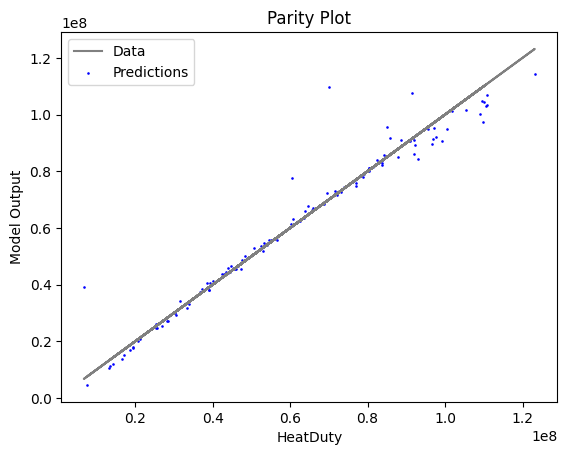

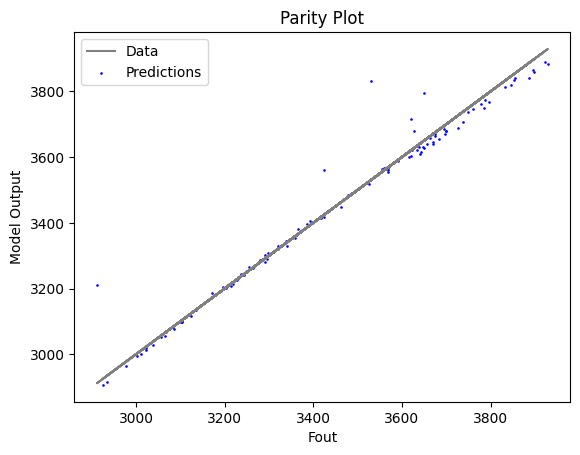

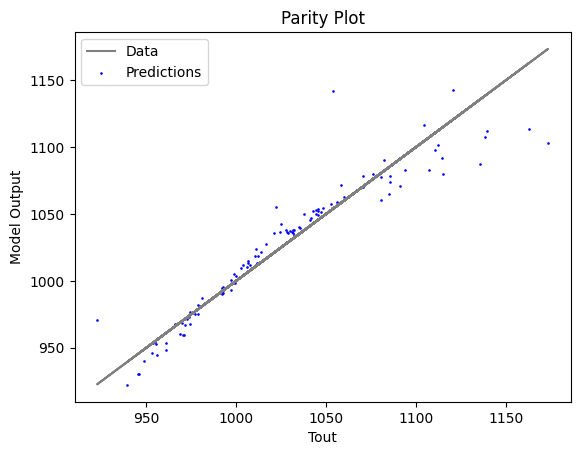

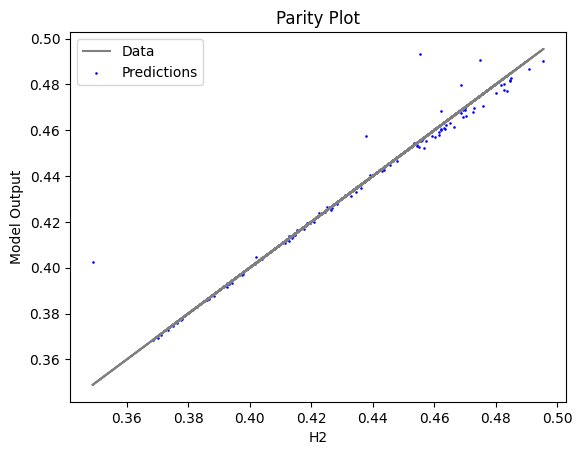

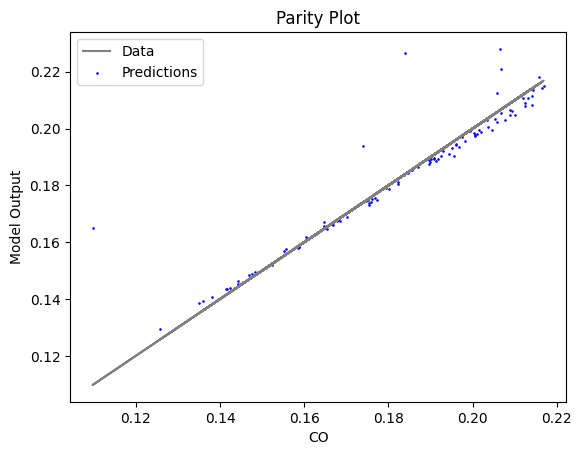

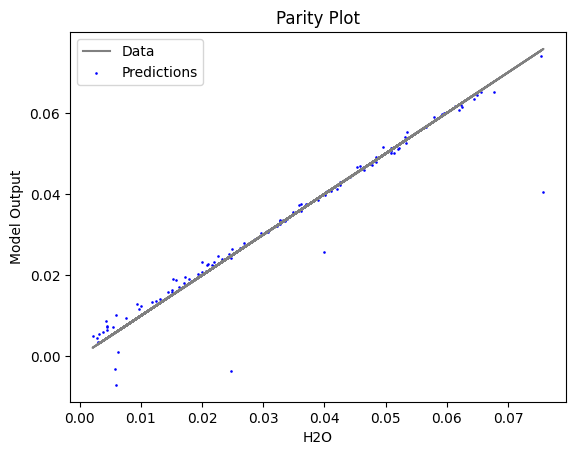

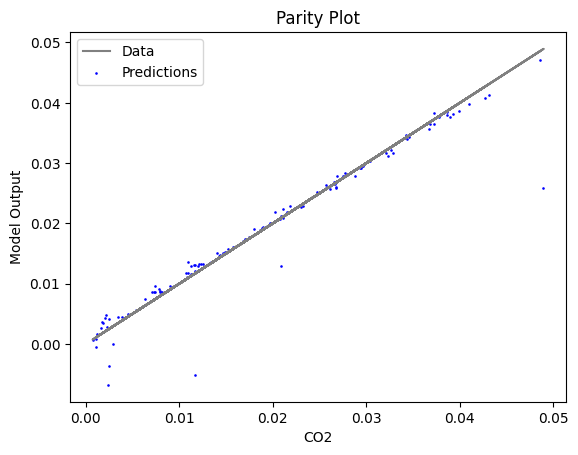

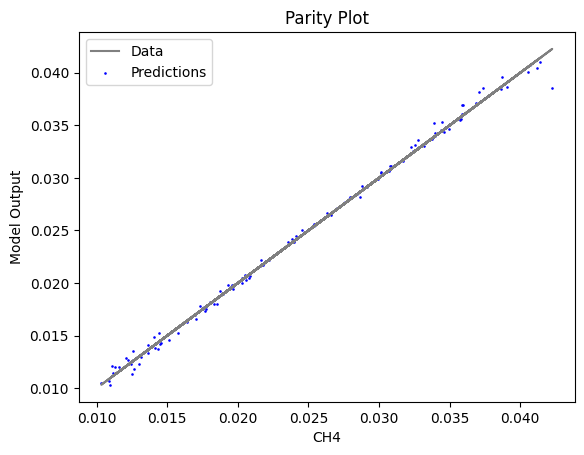

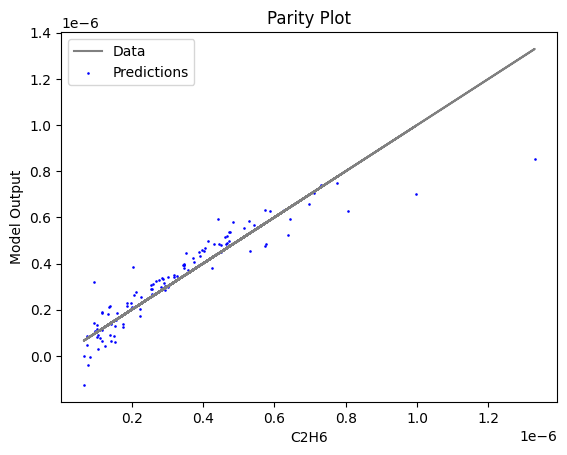

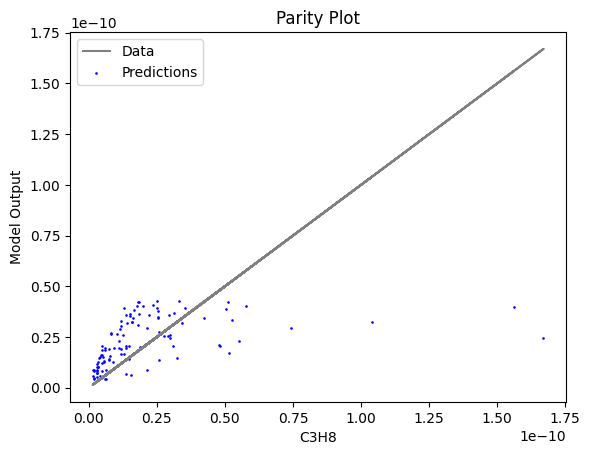

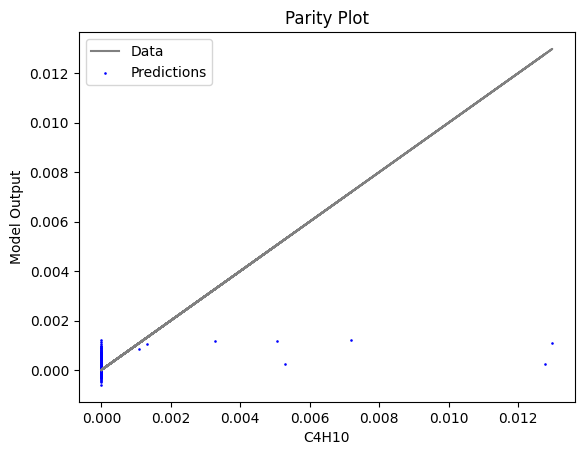

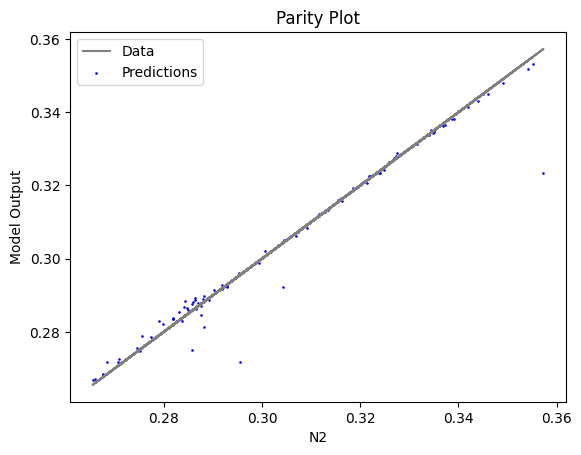

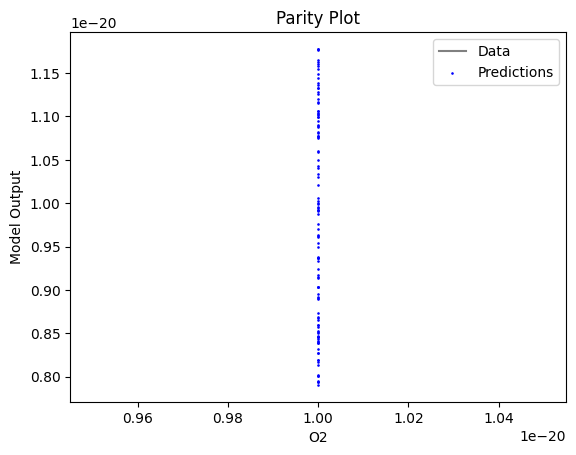

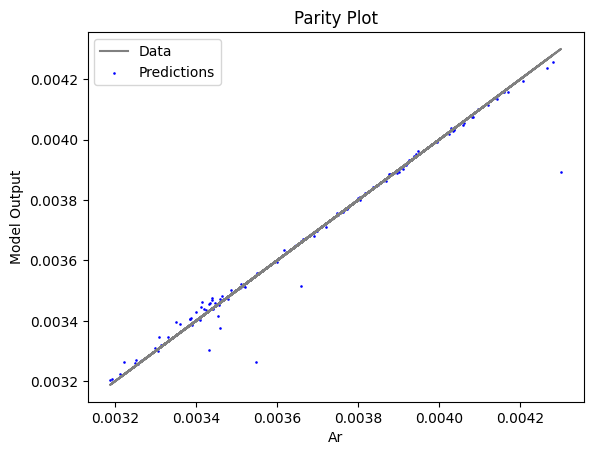

In [54]:
surrogate_parity(alamo_model, data_validation, filename="alamoa_train_parity.pdf")


In [26]:
predicted_alamooutput_data = AlamoSurrogate.evaluate_surrogate(alamo_model,data_validation.iloc[:, :4])

In [58]:
from sklearn.metrics import r2_score

y_true = predicted_alamooutput_data['CO'].values
y_pred = data_validation.iloc[:, 4:]['CO'].values

# Calculate the R-squared value
r2_score(y_true, y_pred)

0.887860794964899